# Лабораторная работа №5
## Transfer Learning

Выполнил Попов Матвей, М8О-408Б-20


В качестве задачи была выбрана классификация комнат на убранные и неубранные.

Чтобы обучить локально, скачайте [архив с датасетом](https://www.kaggle.com/datasets/cdawn1/messy-vs-clean-room/download?datasetVersionNumber=1)
и распакуйте его содержимое в папку `dataset`

In [51]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # интерактивный режим

In [52]:
# Увеличение и нормализация данных для обучения
# Просто нормализация для проверки
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset/archive/images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
dataset_sizes

{'train': 192, 'val': 20}

In [54]:
class_names

['clean', 'messy']

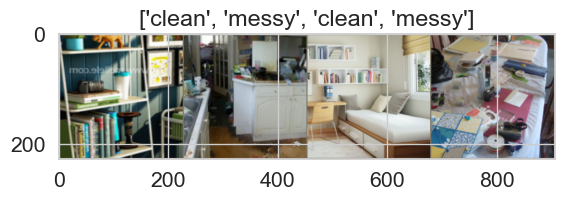

In [55]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # сделайте небольшую паузу, чтобы графики обновились


# Получить пакет обучающих данных
inputs, classes = next(iter(dataloaders['train']))

# Сделать сетку из пакета
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [56]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Создайте временный каталог для сохранения контрольных точек обучения
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Каждая эпоха имеет этап обучения и проверки.
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Установите модель в режим обучения
                else:
                    model.eval()   # Установите модель в режим оценки

                running_loss = 0.0
                running_corrects = 0

                # Перебирать данные.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # обнулить градиенты параметров
                    optimizer.zero_grad()

                    # вперед
                    # отслеживать историю, если только в поезде
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # назад + оптимизировать только на этапе обучения
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # статистика
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # глубокое копирование модели
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # загрузить лучшие веса модели
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [57]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [58]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Здесь размер каждой выходной выборки установлен равным 2.
# В качестве альтернативы его можно обобщить до ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Обратите внимание, что все параметры оптимизируются
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Распад LR на коэффициент 0,1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [59]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6770 Acc: 0.6510
val Loss: 0.2468 Acc: 0.9500

Epoch 1/24
----------
train Loss: 0.7173 Acc: 0.6875
val Loss: 0.1080 Acc: 0.9500

Epoch 2/24
----------
train Loss: 0.4080 Acc: 0.8490
val Loss: 0.1892 Acc: 0.9000

Epoch 3/24
----------
train Loss: 0.4899 Acc: 0.8333
val Loss: 0.3431 Acc: 0.9500

Epoch 4/24
----------
train Loss: 0.3850 Acc: 0.8333
val Loss: 0.0300 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.5042 Acc: 0.7917
val Loss: 0.2409 Acc: 0.8500

Epoch 6/24
----------
train Loss: 0.3717 Acc: 0.8802
val Loss: 0.0054 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.3274 Acc: 0.8646
val Loss: 0.0086 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.4392 Acc: 0.8333
val Loss: 0.0242 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2313 Acc: 0.9010
val Loss: 0.0305 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2593 Acc: 0.8646
val Loss: 0.0294 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1446 Acc: 0.9531
val Loss: 0.0206 Acc: 1.0000

Ep

In [60]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Параметры вновь созданных модулей по умолчанию имеют require_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Обратите внимание, что оптимизируются только параметры последнего слоя.
# в отличие от предыдущего.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Распад LR на коэффициент 0,1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [61]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6154 Acc: 0.6615
val Loss: 0.3184 Acc: 0.9000

Epoch 1/24
----------
train Loss: 0.5116 Acc: 0.7604
val Loss: 0.2291 Acc: 0.9000

Epoch 2/24
----------
train Loss: 0.4587 Acc: 0.7708
val Loss: 0.2280 Acc: 0.9000

Epoch 3/24
----------
train Loss: 0.6002 Acc: 0.7135
val Loss: 0.3100 Acc: 0.9000

Epoch 4/24
----------
train Loss: 0.4361 Acc: 0.7917
val Loss: 0.2749 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.3811 Acc: 0.8281
val Loss: 0.1601 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.4602 Acc: 0.8229
val Loss: 0.3876 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.3737 Acc: 0.8333
val Loss: 0.1572 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.3195 Acc: 0.8490
val Loss: 0.1893 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.2585 Acc: 0.9010
val Loss: 0.1284 Acc: 0.9500

Epoch 10/24
----------
train Loss: 0.4198 Acc: 0.8385
val Loss: 0.1408 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.3458 Acc: 0.8333
val Loss: 0.1602 Acc: 0.9500

Ep

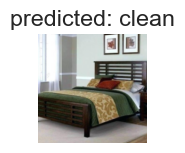

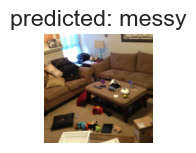

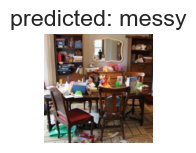

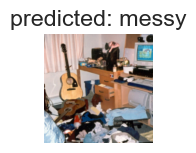

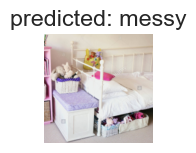

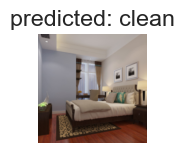

In [62]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [63]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

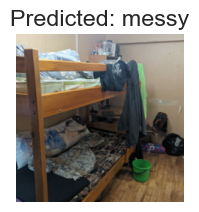

In [64]:
visualize_model_predictions(
    model_conv,
    img_path='example.jpg'
)

plt.ioff()
plt.show()

## Вывод

Проделав лабораторную работу, я дообучил предобученную нейронную сеть, чтобы она смогла определять, 
является ли комната убранной или неубранной. Чтобы проверить её работоспособность, я использовал её
на фотографии моей комнаты в общежитии. К сожалению, я и мой сосед не поддерживаем нашу комнату в чистоте.
